## Backgound
Analysis of the Chemotaxis model described by Spiro et al., PNAS, 1999.
The model describes the receptor state along 3 dimensions:
  - bound to a ligand
  - phosphorylated
  - degree of methylation (considers 2, 3, 4)
  
Key variables are:
   - Y, Yp - concentrations of CheY and its phosphorylated form
   - B, Bp - concentrations of CheB and its phosphorylated form
   - L - ligand concentration
   - f<state>, t<state> - "f" indicates the fraction of the concentration in the state, "t" is the total
     <state> is a 3 character string, such as "TT2". T/F indicates the boolean value; the last is an integer.
     
Below is a figure from Spiro describing the state structure of receptors.

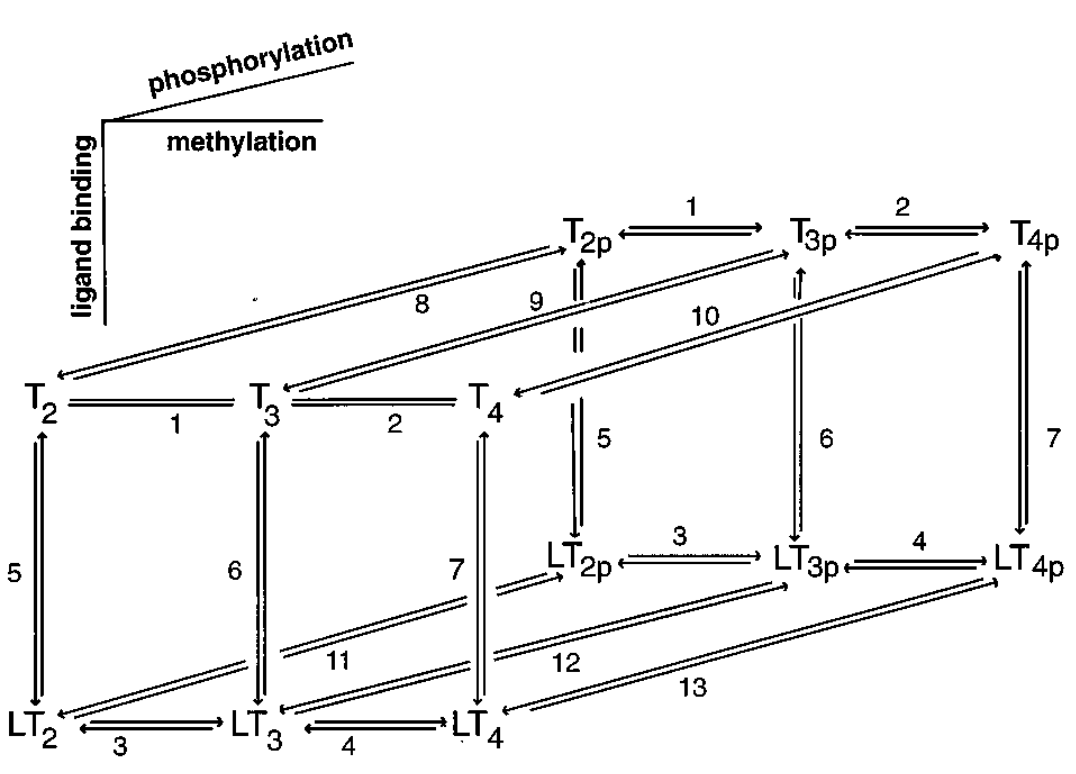

In [3]:
from IPython.display import Image, display
display(Image(filename='img/receptor_states.png'))

## Summary

Initially, we consider a step response. Later, we repeat the same analysis for a ramp. These correspond to the analyses done by Spiro.

Most of the analysis is done using fractional concentrations (variables that begin with "f"). We begin by justifying this.

Next, we analyze the effects of a step response. "Perfect adaptation" is possible if the step is small enough.

## Software Dependencies
The model and various utility functions are in the python modules chemotaxis_model and data_plotter.

In [4]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import tellurium as te
from chemotaxis_model import ChemotaxisModel, StateAggregationFactory
from data_plotter import DataPlotter
model = ChemotaxisModel()

/home/ubuntu/miniconda2/lib/python2.7/site-packages/tellurium/notebooks/__init__.py:16: UserWarning: Notebook tools are not imported, due to missing dependencies.
  warnings.warn("Notebook tools are not imported, due to missing dependencies.")


## Antimony Model

In [5]:
print model.getModel()


        J0: $x0 -> L; k0*x0
        # REACTIONS from Spiro, Table 3
        # Methylation
        J1: T2R -> T3 + R; k1c*T2R
        J2: T3R -> T4 + R; k2c*T3R
        J3: LT2R -> LT3 + R; k3c*LT2R
        J4: LT3R -> LT4 + R; k4c*LT3R
        #   Details of Tn + R <-> TnR
        J5: T2R -> T2 + R; k1a*T2R
        J6: T2 + R -> T2R; k1b*T2*R
        J7: T3R -> T3 + R; k2a*T3R
        J8: T3 + R -> T3R; k2b*T3*R
        #J9: T4R -> T4 + R; k3a*T4R
        #J10: T4 + R -> T4R; k3b*T4*R
        #   Details of LTn + R <-> LTnR (not in Spiro)
        J11: LT2R -> LT2 + R; k1a*LT2R
        J12: LT2 + R -> LT2R; k1b*LT2*R
        J13: LT3R -> LT3 + R; k2a*LT3R
        J14: LT3 + R -> LT3R; k2b*LT3*R
        #J15: LT4R -> LT4 + R; k3a*LT4R
        #J16: LT4 + R -> LT4R; k3b*LT4*R
        # Demethylation reactions
        J17: T3 + Bp -> T2 + Bp; k_1*T3*Bp
        J18: T4 + Bp -> T3 + Bp; k_2*T4*Bp  
        J19: LT3 + Bp -> LT2 + Bp; k_3*LT3*Bp
        J20: LT4 + Bp -> LT3 + Bp; k_4*LT4*Bp
 

## Common Codes Used in this Analysis

In [6]:
# Runs simulation and creates global variables used in analysis
def sim(elements=None):
    """
    Runs the simulation and creates global names
    Input: global variable model - the ChemotaxisModel
        elements - elements to add to the model
    Output: global variables - plotter, result
    """
    if elements is None:
      elements = []
    global plotter, result
    model = ChemotaxisModel()
    for element in elements:
      model.appendToModel(element)
    model.initialize()
    result = model.run(end=300)
    plotter = DataPlotter(model)


## Justification for Fractional Concentrations

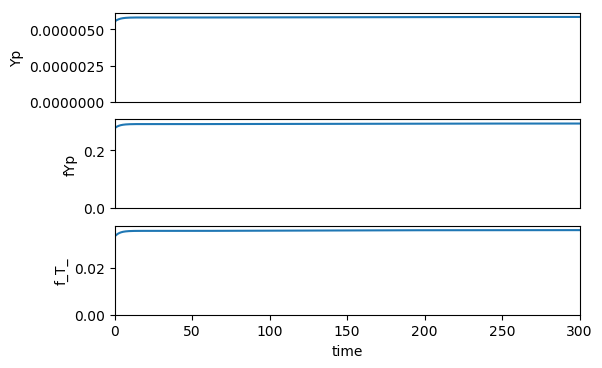

In [7]:
# Analysis for L = 0
sim()
plotter.lines(["Yp", "fYp", "f_T_"])

Observations
- Although the scales differ, the shape of Yp and fYp are identical.
- The Yp response corresponds to the shape of the fraction of methylated receptor

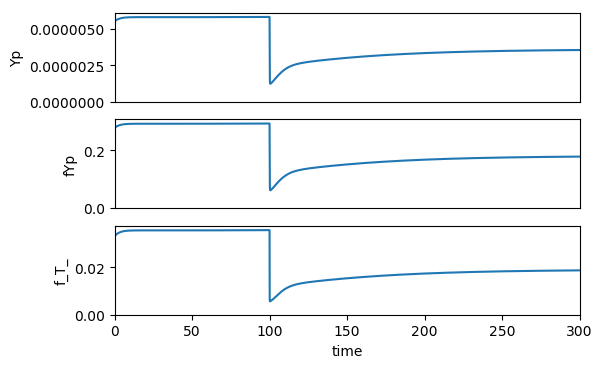

In [8]:
# Step Analysis for a change at 100
sim(elements=["at (time > 100): L = 11e-6"])
plotter.lines(["Yp", "fYp", "f_T_"])

Observations

- Once again, it suffices to look at the fraction of methylated receptors.

## Analysis of Step Response
The goal here is to understand the dynamics of the receptor state for a step response.
From the foregoing, we established that it's sufficient to look at the fraction of receptors that are in the phosphorylated state (since this correlates with Yp). Now we want to understand what substates contribute to phosphorylated receptors.

Spiro shows a step response plot with L going from 0 to 11uM and "perfect adaption of Yp. We do not see this. Possibly, this is because he used a model with more methylation levels. Below is Spiro's step response curve.

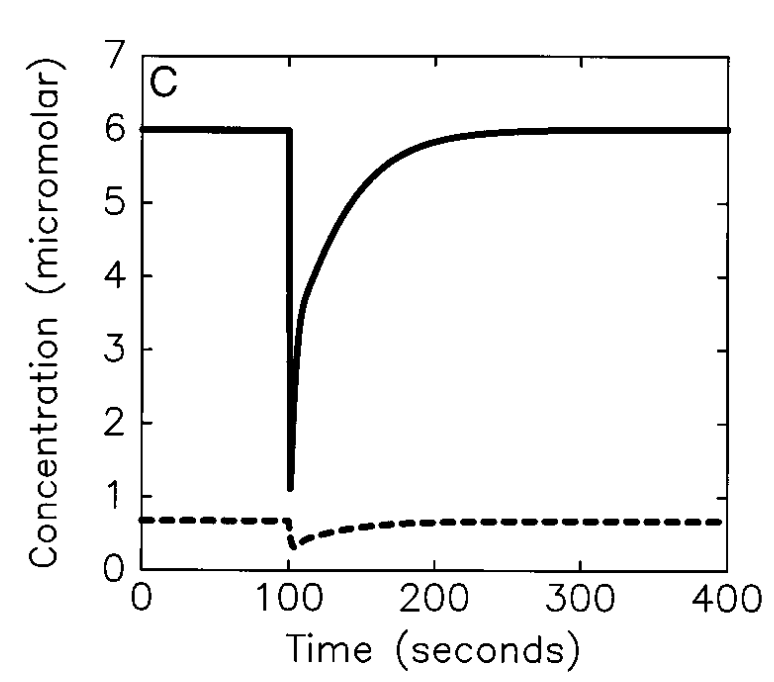

In [9]:
from IPython.display import Image, display
display(Image(filename='img/spiro_largestep.png'))

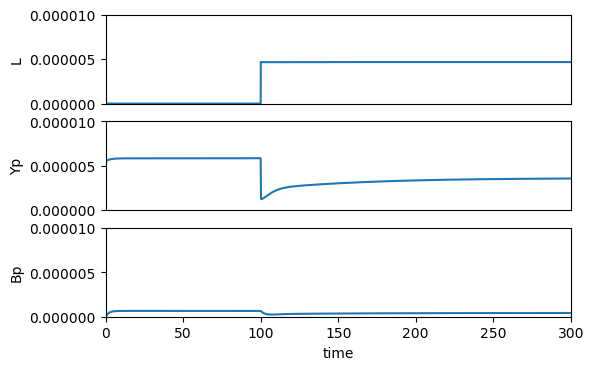

In [10]:
# What is the simulated step response for our model that corresponds to the Spiro?
# The solid line above is Yp and the dashed line is Bp; ligand concentration change is not shown.
sim(elements=["at (time > 100): L = 11e-6"])
plotter.lines(["L", "Yp", "Bp"], yrange=[0, 10e-6])

Observations
- Yp starts at 6uM, as in Spiro. However, after the step, it does not recover.
- Bp also does not recover. This may indicate that we are not demethylating (although demethylating would tend to further decrease receptor phosphorylation and hence Yp concentration).

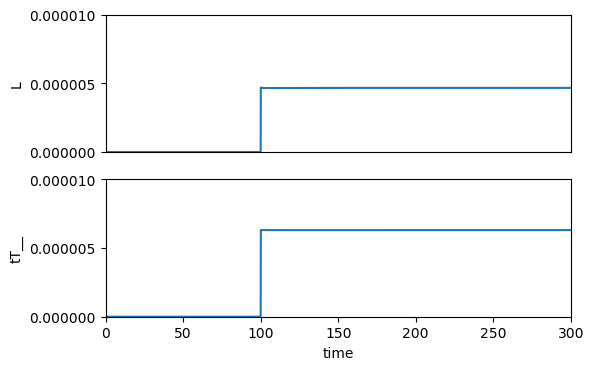

In [11]:
# Where does the ligand go?
sim(elements=["at (time > 100): L = 11e-6"])
plotter.lines(["L", "tT__"], yrange=[0, 10e-6])

Observations
- There are 8uM of receptors and we add 11uM of ligand. We end up with 6uM of bound receptors, and the rest is free Ligand. 
- k_on = k5 = 7e7; k_off = k_5 = 70. But since k_on is bimolecular, the reaction rate is much slower than the mono-molecular reverse reaction.

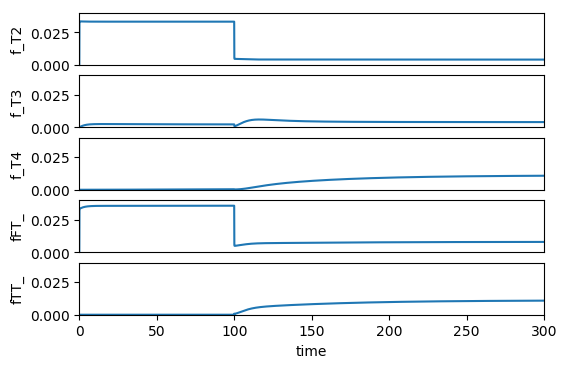

In [17]:
# Breakdown the state phosphorylations by ligand bound and methylation level
sim(elements=["at (time > 100): L = 11e-6"])
plotter.lines(["f_T2", "f_T3", "f_T4", "fFT_", "fTT_"], yrange=[0,.04])

Observations
 - The unbound ligands have a very low phosphorylation level after the step
 - Higher methylated receptors have higher phosphorylation levels
 - methylation of 4 seems to plateau
 
Questions
 - Do we need more methylation levels to respond adequately to a large step?

## Ramp analysis

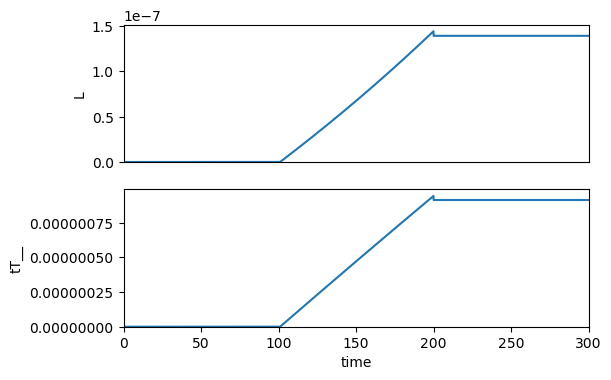

In [12]:
# Where does the ligand go?
elements = ["at (time > 101): k0 = 0.011e-6", "at (time > 200): k0 = 0, L=0.11e-6"]
sim(elements=elements)
plotter.lines(["L", "tT__"])